In [1]:
# import libraries
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import L2NormSquared, L1Norm, TotalVariation, OperatorCompositionFunction
from cil.optimisation.operators import BlockOperator, GradientOperator
from cil.framework import ImageGeometry, AcquisitionGeometry
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import show2D

import numpy as np
import os, sys

import tomophantom
from tomophantom import TomoP2D

In [2]:
# Load a tomophantom image 
model = 8 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D_np = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N, voxel_size_x = 0.5, voxel_size_y = 0.5)

phantom2D = ig.allocate()
phantom2D.fill(phantom2D_np)

In [3]:
# Create Acquisition Geometry
detectors =  int(np.sqrt(2)*N)
angles = np.linspace(0, np.pi, 180, dtype=np.float32)

ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles,angle_unit="radian")\
                        .set_panel(detectors, pixel_size=0.5)

In [4]:
device = "gpu"

In [5]:
# Create Projection Operator
A = ProjectionOperator(ig, ag, device )

In [6]:
# Create projection data and corrupt with noise
np.random.seed(10)

data = A.direct(phantom2D)
noisy_data = ag.allocate()
noisy_data.fill(data.as_array() + np.random.normal(0, 0.5, ag.shape))

In [7]:
# Regularisation parameters for L1, L2NormSquared and TV regularisers

f = OperatorCompositionFunction(0.5 * L2NormSquared(b=noisy_data), A)

alphaL1 = [100, 1000, 1500]
alphaL2s = [100, 500, 5000]
alphaTV = [1, 1e3, 1.8e3]

regulariser = {"L1":L1Norm(),
               "L2s":L2NormSquared(),
               "TV":TotalVariation(max_iteration=100, lower = 0.)}

In [8]:
print("This will take some time.\n We have 3 regularisers for 3 different parameters and 200 iterations. \n")

reconstructions = []
info = []

for reg, fun  in regulariser.items():
    
    for i in range(3):
        
        if reg=="L1":
            
            alpha = alphaL1[i]
            
        elif  reg=="L2s":
        
            alpha = alphaL2s[i]

        elif reg=="TV":
        
            alpha = alphaTV[i]         

        else:    
            print("No regulariser")
    
        g = alpha * fun
        print("Regulariser is {} and alpha = {}\n".format(reg, alpha))
        
        fista = FISTA(initial=ig.allocate(),f=f, g=g, max_iteration=200, update_objective_interval=50)
        fista.run(verbose=1)      
        
        reconstructions.append(fista.solution)
        info.append(" {} , alpha = {}" .format(reg, alpha))

This will take some time.
 We have 3 regularisers for 3 different parameters and 200 iterations. 

Regulariser is L1 and alpha = 100

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          3.97483e+06
       50        200         0.026          4.51926e+05
      100        200         0.026          4.51680e+05
      150        200         0.027          4.51623e+05
      200        200         0.027          4.51598e+05
-------------------------------------------------------
      200        200         0.027          4.51598e+05
Stop criterion has been reached.

Regulariser is L1 and alpha = 1000

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          3.97483e+06
       50        200         0.026          3.01481e+06


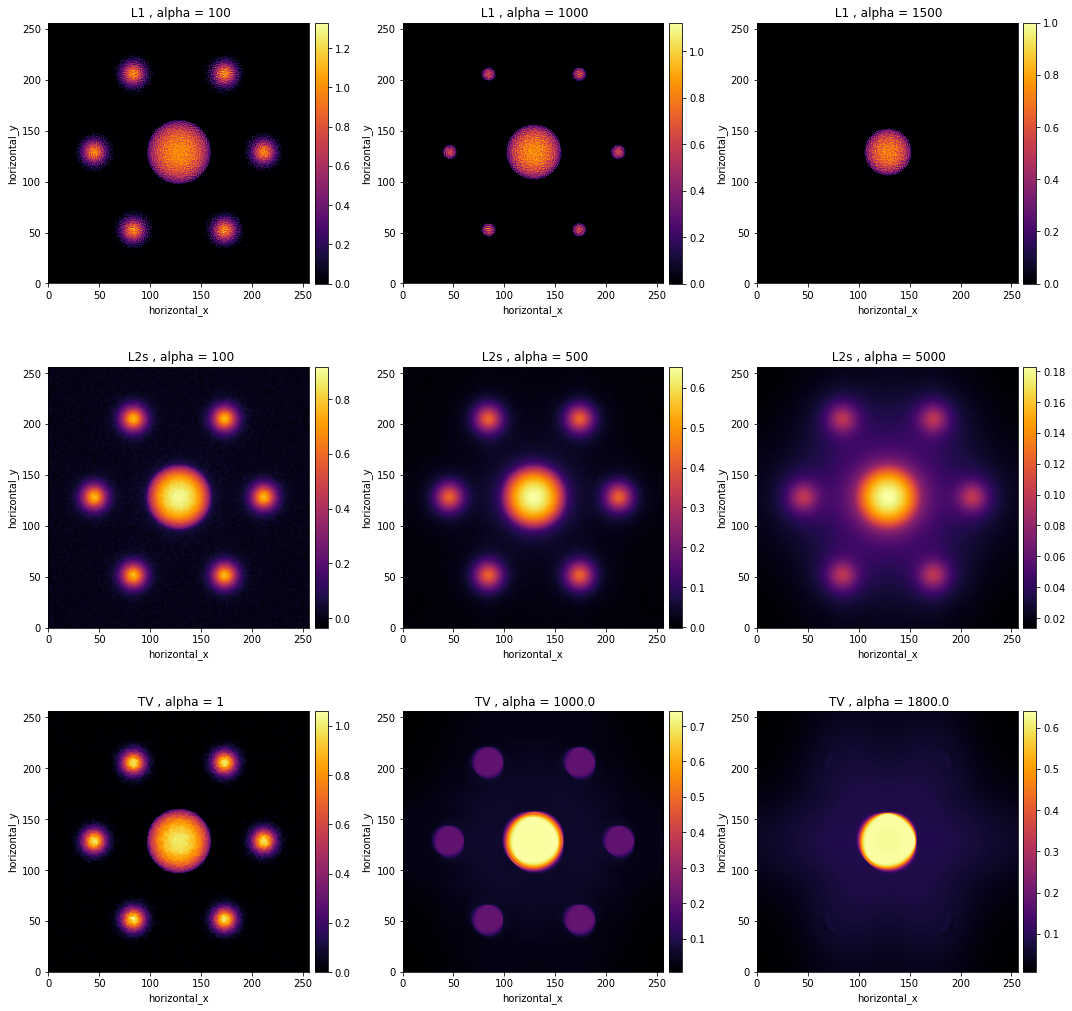

In [9]:
show2D(reconstructions, num_cols=3, cmap="inferno", title=info)